### ===Task===

Your work: Let's modify the above scratch code to
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

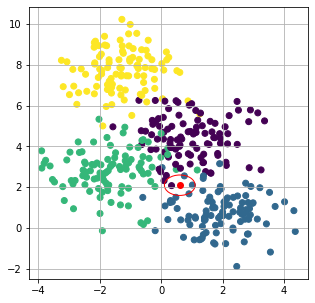

In [2]:
#let's consider the following 2D data with 4 classes
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=400, centers=4,
                  random_state=0, cluster_std=1.0)

xfit = np.linspace(-1, 3.5)

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

#where should this value be classified as?
ax.plot([0.6], [2.1], '.', color='red', markeredgewidth=2, markersize=10)

#let's say roughly 5 neighbors
circle = plt.Circle((0.6, 2.1), 0.5, color='red', fill=False)
ax.add_artist(circle)

In [3]:
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        
    def find_neighbors_dist(self,X_train, X_test):
        #create newaxis simply so that broadcast to all values
        sqlist = np.zeros((X_test.shape[0],X_train.shape[0]))
        for i in range(X_test.shape[0]):
             for j in range(X_train.shape[0]):
                sqlist[i][j] = np.sqrt(np.sum((X_test[i]-X_train[j])**2))
                
        dist = sqlist
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)[:, 0:self.k]   
          
        return neighbors_ix
    
    def predict(self, X_train, X_test, y_train):
        
        neighbors_ix = self.find_neighbors_dist(X_train, X_test)
        
        yhat = np.zeros(X_test.shape[0])
        yhat_prob = np.zeros(X_test.shape[0])
        
        for ix, y in enumerate(y_train[neighbors_ix]):
            yhat[ix], yhat_prob[ix] = self.get_most_common(y, X_train, X_test)
        return yhat, yhat_prob
    
    
    
    def get_most_common(self, y_sorted, X_train, X_test):
        y_nearest = y_sorted[0:self.k]
        self.n_classes = len(np.unique(y_sorted))
        bincount = np.bincount(y_nearest, minlength=self.n_classes)
        binsort = bincount.argsort()
        highest = binsort[-1:][0]
        second_highest = binsort[-2:][0]
        if bincount[highest] == bincount[second_highest]:
            y_nearest = y_sorted[0: self.k+1]
            return np.bincount(y_nearest).argmax(), bincount[highest] / X_train.shape[0]
        return np.bincount(y_nearest).argmax(), bincount[highest] / X_train.shape[0]    
        
    def cv(self, X_train, y_train, cv, lowest_k, highest_k): # k is a range of values
        k = np.arange(lowest_k,highest_k+1)
        m = X_train.shape[0] 
        size = int(round(m/cv))
        yhat_cv = np.zeros((len(k), cv))
        yhat_cv_prob = np.zeros((len(k), cv))
        
        for k_idx, kneighbors in enumerate(k): #for different value of k
            self.k = kneighbors
            for idx, i in enumerate(range(0, m, size)): # for different set in cv
                #to divide into given size of cv
                X_testcv = X_train[i:i+size]
                y_testcv = y_train[i:i+size]
                X_traincv = np.concatenate((X_train[:i], X_train[i+size:]))
                y_traincv = np.concatenate((y_train[:i], y_train[i+size:]))
                yhat, yhat_prob = self.predict(X_traincv, X_testcv, y_traincv)
                accuracy = np.sum(yhat == y_testcv)/len(y_testcv)
                yhat_cv[k_idx, idx] = accuracy
                yhat_cv_prob[k_idx, idx] = yhat_prob.mean()
        return yhat_cv, yhat_cv_prob
    


In [5]:
model = KNN()
yhat = model.predict(X_train, X_test, y_train)

In [6]:
from sklearn.metrics import classification_report

#choose model with highest score
model = KNN(k=4)
yhat, yhat_prob = model.predict(X_train, X_test, y_train)

print("=========Accuracy=======")
print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))
print("=========Probability score=======")

=========Accuracy=======
Accuracy:  0.925
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.97      0.92      0.94        36
           2       0.92      0.88      0.90        25
           3       0.96      1.00      0.98        27

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120

=========Probability score=======


In [7]:
l = 3
h = 6    

cv_score, prob_score = model.cv(X_train, y_train,cv = 4, lowest_k= l,highest_k = h)
cv_score = cv_score.mean(axis=1)
prob_score = prob_score.mean(axis=1)
k = np.arange(l,h+1)
for k_idx, kneighbors in enumerate(k):
    print(f"Score with k={kneighbors}: ", cv_score[k_idx], "and prob_score of ", prob_score[k_idx])

Score with k=3:  0.9214285714285715 and prob_score of  0.013469387755102038
Score with k=4:  0.9107142857142858 and prob_score of  0.01770408163265306
Score with k=5:  0.9214285714285715 and prob_score of  0.02209183673469387
Score with k=6:  0.925 and prob_score of  0.026360544217687073
